In [1]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [2]:
input_pose = Input(shape=[5000, 6])
tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_pose = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [30]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
rng = np.random.default_rng(12345)
order = np.arange(0,400)
rng.shuffle(order)
x_train_bad = x_train_bad[order]
y_train_bad = y_train_bad[order]
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [64]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    # bn = BatchNormalization()(res_add)
    # return bn
    return res_add

In [78]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_pose)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_pose, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
# FC_l1 = Dense(16, activation="relu")(flatten)
# FC_l2 = Dense(16, activation="relu")(FC_l1)
# FC_l3 = Dense(8, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="sigmoid")(FC_l3)
FC_l1 = Dense(120, activation="relu")(flatten)
FC_l2 = Dense(80, activation="relu")(FC_l1)
FC_l3 = Dense(32, activation="relu")(FC_l2)
last_layer = Dense(2, activation="relu")(FC_l3)

output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [79]:
model_pose = Model(inputs=[input_pose], outputs=[output])

In [87]:
# opt = SGD(learning_rate = 2e-5, momentum = 0.9, nesterov=True)
opt = SGD(learning_rate = 2e-6, momentum = 0.2)
model_pose.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [88]:
model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=4)

Epoch 1/4
13/13 [==============================] - 39s 3s/step - loss: 0.6931 - accuracy: 0.9625 - val_loss: 0.6931 - val_accuracy: 0.9000
Epoch 2/4
13/13 [==============================] - 35s 3s/step - loss: 0.6931 - accuracy: 0.9675 - val_loss: 0.6931 - val_accuracy: 0.9000
Epoch 3/4
13/13 [==============================] - 35s 3s/step - loss: 0.6931 - accuracy: 0.9725 - val_loss: 0.6931 - val_accuracy: 0.9000
Epoch 4/4
13/13 [==============================] - 36s 3s/step - loss: 0.6931 - accuracy: 0.9750 - val_loss: 0.6931 - val_accuracy: 0.9000


2/2 [==============================] - 2s 259ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 0]
[[0.83333333 0.        ]
 [0.16666667 1.        ]]


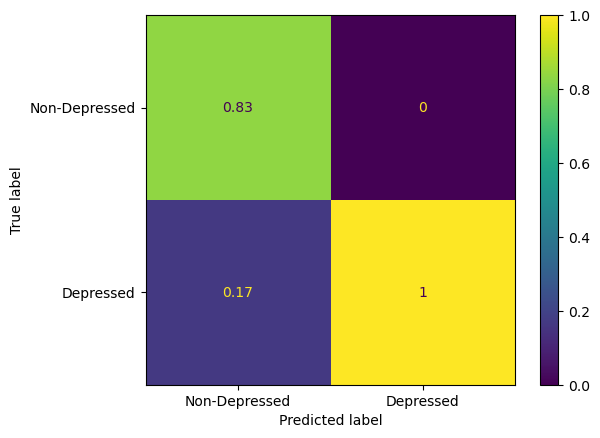

Accuracy = 0.9166666666666667
Recall = 0.8571428571428571
Precision = 1.0
F1-score = 0.923076923076923


In [89]:
#Predict
x = x_dev_bad
y = y_dev_bad
y_pose_prediction = model_pose.predict(x)
y_pose_prediction = np.argmax(y_pose_prediction, axis = 1)

# where_0 = np.where(y_pose_prediction == 0)
# where_1 = np.where(y_pose_prediction == 1)

# y_pose_prediction[where_0] = 1
# y_pose_prediction[where_1] = 0

# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_pose_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [10]:
# model_pose.save("saved_models/made_up_works")